In [26]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import linregress

In [3]:
basicFileName="basic_data.csv"
basicDF=pd.read_csv('../data/'+basicFileName)
basicDF.drop_duplicates(inplace=True)
basicDF['Symbol'].to_csv('../data/'+'ETFs.csv',index=False)
#Inception记录股票上市时间
firstDF=basicDF[['Symbol','Fund Name','Assets','Category','Index','Inception','Volume']]
print(len(firstDF))
firstDF.dropna(inplace=True,subset=['Category'])
print(len(firstDF))

3963
3748


/tmp/ipykernel_1450455/700821110.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firstDF.dropna(inplace=True,subset=['Category'])


In [4]:
#计算每类股票的资产总和
def category_assets(df):
    require_colums= ["Category","Assets"]
    for col in require_colums:
        if col not in firstDF.columns:
            print("Error: Missing column "+col)
            return

    df["Assets"]=pd.to_numeric(df["Assets"],errors='coerce')
    categorys=df.groupby("Category")["Assets"].sum().reset_index()
    categorys=categorys.sort_values("Assets",ascending=False)
    
    print("\nNet Assets by Category:\n")
    
    
    categorys.to_csv("../data/category_assets.csv")
    return categorys

categorys=category_assets(firstDF)
categorys.to_csv("../data/categorys.csv")
print(categorys["Category"])
# print(categorys[categorys["Category"]=="Large Blend"])


Net Assets by Category:

50                    Large Blend
51                   Large Growth
52                    Large Value
26            Foreign Large Blend
57                  Mid-Cap Blend
                  ...            
103        Target-Date Retirement
76     Muni New York Intermediate
101              Target-Date 2060
102             Target-Date 2065+
114              World Allocation
Name: Category, Length: 115, dtype: object


/tmp/ipykernel_1450455/4031137877.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Assets"]=pd.to_numeric(df["Assets"],errors='coerce')


In [5]:
#Setp3:删除流动性和资产小于 val 的基金

def filter_fund(df,categorys):
    require_colums= ["Category","Assets","Volume"]
    for col in require_colums:
        if col not in firstDF.columns:
            print("Error: Missing column "+col)
            return

    totAssets=categorys["Assets"].sum()
    print("Total Assets: ",totAssets)
        
    cateVal={"-1":-1}
    for etf in df["Category"]:
        cateVal[etf]=categorys[categorys["Category"]==etf]["Assets"].values[0]
    
    df["calval"]=df["Category"].map(cateVal)
    filtered_df = df[
        (df['Assets'] > 0.001 * totAssets) |
        (df['Assets'] > df['Category'].map(lambda ca: 0.05 * cateVal.get(ca, 0)))
    ]
    
    filtered_df.to_csv("../data/filter_fund.csv")
    
    filtered_df["Symbol"].to_csv("../data/ETF1s.csv",index=False)
    return df

df2=filter_fund(firstDF,categorys)
categorys=category_assets(firstDF)


Total Assets:  10618004254149.0

Net Assets by Category:



/tmp/ipykernel_1450455/1702711572.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["calval"]=df["Category"].map(cateVal)
/tmp/ipykernel_1450455/4031137877.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Assets"]=pd.to_numeric(df["Assets"],errors='coerce')


Alpha: 0.0001664940081468543
Beta: 1.1054567265769366


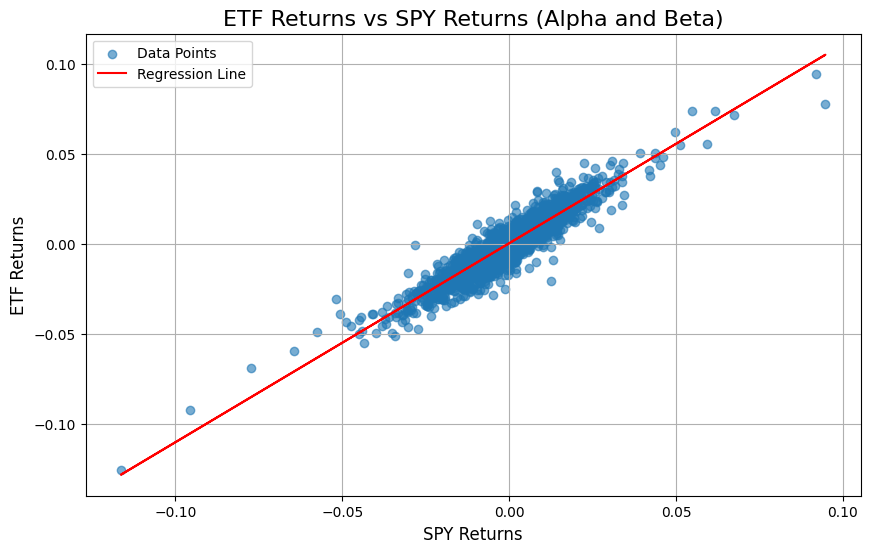

(0.0001664940081468543, 1.1054567265769366)

In [ ]:
# linear_regression(SPY,ETF)
# find alpha and beta
def linear_regression(basicDf1,basicDf2):
    basicDf1["Date"]=pd.to_datetime(basicDf1["date"]).dt.date
    basicDf2["Date"]=pd.to_datetime(basicDf2["date"]).dt.date
    common_dates=set(basicDf1['Date']).intersection(set(basicDf2['Date']))
    common_dates=sorted(list(common_dates))
    df1=basicDf1[basicDf1['Date'].isin(common_dates)]
    df2=basicDf2[basicDf2['Date'].isin(common_dates)]
    df=pd.merge(df1[['Date','close']],df2[['Date','close']],on='Date',suffixes=('_1','_2'))
    df['return1']=df1['close'].pct_change()
    df['return2']=df2['close'].pct_change()
    df=df.dropna()
    x = sm.add_constant(df['return1'])
    y = df['return2']
    
    model = sm.OLS(y, x).fit()
    alpha = model.params['const']
    beta = model.params['return1']
    
    # print("Alpha:", alpha)
    # print("Beta:", beta)
    # # 绘制 SPY 和 ETF 收益率的散点图和回归线
    # plt.figure(figsize=(10, 6))
    # plt.scatter(df['return1'], df['return2'], label='Data Points', alpha=0.6)
    # plt.plot(df['return1'], alpha + beta * df['return1'], color='red', label='Regression Line')

    # # 添加图表标题和标签
    # plt.title('ETF Returns vs SPY Returns (Alpha and Beta)', fontsize=16)
    # plt.xlabel('SPY Returns', fontsize=12)
    # plt.ylabel('ETF Returns', fontsize=12)
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    return alpha,beta
    

# dfSPY=pd.read_csv("../data/daily_data/SPY_daily.csv")
# dfVOO=pd.read_csv("../data/daily_data/QQQ_daily.csv")
# linear_regression(dfSPY,dfVOO)    

In [109]:
#计算单个ETF的alpha和beta
def linear_regression(ticker):
    
    #df= ticker 的K 线图
    try:
        df=pd.read_csv('../data/daily_data/'+ticker+'_daily.csv')
    except Exception as e:
        print("Error in reading daily data :" + ticker+ " "+str(e)+"\n")
        return 
    list_alpha=[]
    list_beta=[]
    for year in range(2010,2026):
        etf_Return_year=df.loc[df.index.year==year,'Return']
        spy_Return_year=spy_data.loc[spy_data.index.year==year,'Return']
        if len(etf_Return_year)==0 or len(spy_Return_year)==0:
            list_alpha.append(np.nan)
            list_beta.append(np.nan)
            continue
        #日期对齐和缺失数据补全（前项填充）
        all_dates=pd.date_range(start=max(etf_Return_year.index.min(),spy_Return_year.index.min()),end=min(etf_Return_year.index.max(),spy_Return_year.index.max()))
        etf_Return_year=etf_Return_year.reindex(all_dates).ffill()
        spy_Return_year=spy_Return_year.reindex(all_dates).ffill()
        X=spy_Return_year.values.reshape(-1,1)
        y=etf_Return_year.values
        model=LinearRegression().fit(X,y)
        alpha=model.intercept_*252
        beta=model.coef_[0]
        list_alpha.append(alpha)
        list_beta.append(beta)
    return list_alpha,list_beta